In [150]:
%matplotlib inline
import scipy as scp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16, 9)})
import thinkbayes2

# Exercise 10.1

We will assume that we will get the two joint distributions of $\mu$ and $\sigma$ for two different groups. 



Now the only thing left is to get the joint distributions for the two groups. I will use a different dataset for two groups of pupils whos reading skills were tested. There is one treatment group who got special reading activities during four weeks of school and another one without any special treatment. 

In [151]:
df = pd.read_csv('/home/christoph/python_projects/ThinkBayes2/data/drp_scores.csv', comment='#', header=1, sep='\t')

skills_one, skills_two = [], []
for group, reading_skills in zip(df.Treatment.values, df.Response.values):
    if group == 'Treated':
        skills_one.append(reading_skills)
    else:
        skills_two.append(reading_skills)
skills_one[:5], skills_two[:5]

([24, 43, 58, 71, 43], [42, 43, 55, 26, 62])

In [152]:
import itertools
mu_hypos, sigma_hypos = np.linspace(20, 80, 121), np.linspace(1, 30, 30)

hypo_combs = list(itertools.product(mu_hypos, sigma_hypos))

class ReadingGroup(thinkbayes2.Suite):       
    def Likelihood(self, data, hypo):
        mu, sigma = hypo
        return scp.stats.norm.pdf((data - mu) / sigma) / sigma
    
group_treated = ReadingGroup(hypo_combs)
group_treated.UpdateSet(skills_one)

control_group = ReadingGroup(hypo_combs)
control_group.UpdateSet(skills_two)


1.5112229332579289e-44

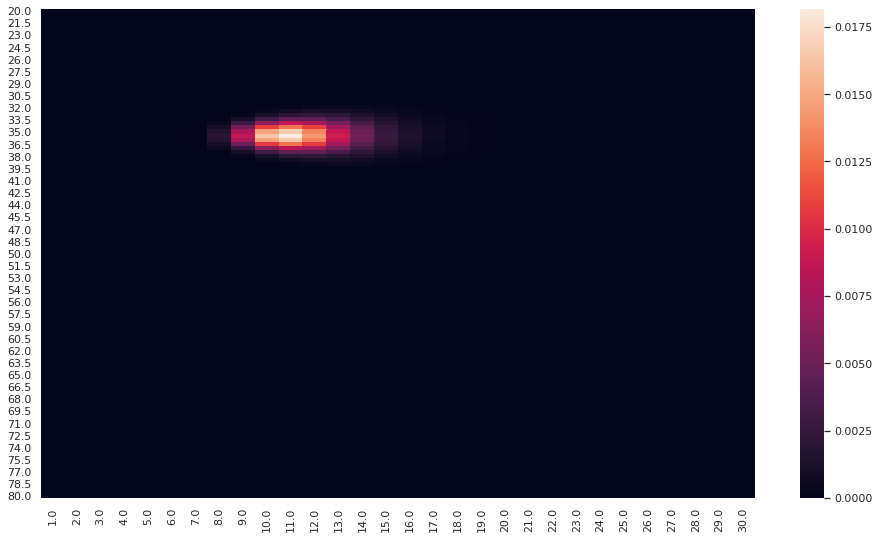

In [153]:
def plot_heatmap(joint_group_dist):
    probs = np.zeros((len(mu_hypos), len(sigma_hypos)))
    min_mu, min_sigma = min(mu_hypos), min(sigma_hypos)
    for (mu, sig), prob in joint_group_dist.SortedItems():
        probs[int(mu - min_mu), int(sig - min_sigma)] = prob

    sns.heatmap(
        pd.DataFrame(
            probs,
            index=[str(one) for one in mu_hypos],
            columns=[str(one) for one in sigma_hypos]
        )
    )

plot_heatmap(group_treated)

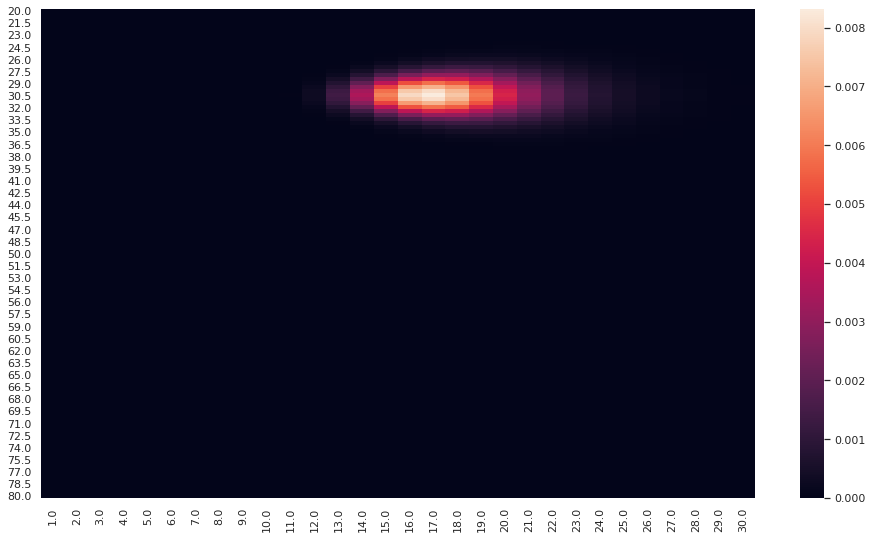

In [154]:
plot_heatmap(control_group)

So from the heatmaps it look like that the mean is lower for the control group, but also the spread is bigger. In the treatment group on the other hand the average reading skills are higher

Now we compute the effect size.

$ e = \frac {\mu_1 - \mu_2} { \frac {\sigma_1 + \sigma_2} {2} }  $

Using two different distributions for the mean and the standard deviation computing $ e $ we would get a lot of different values for all the different combination. 

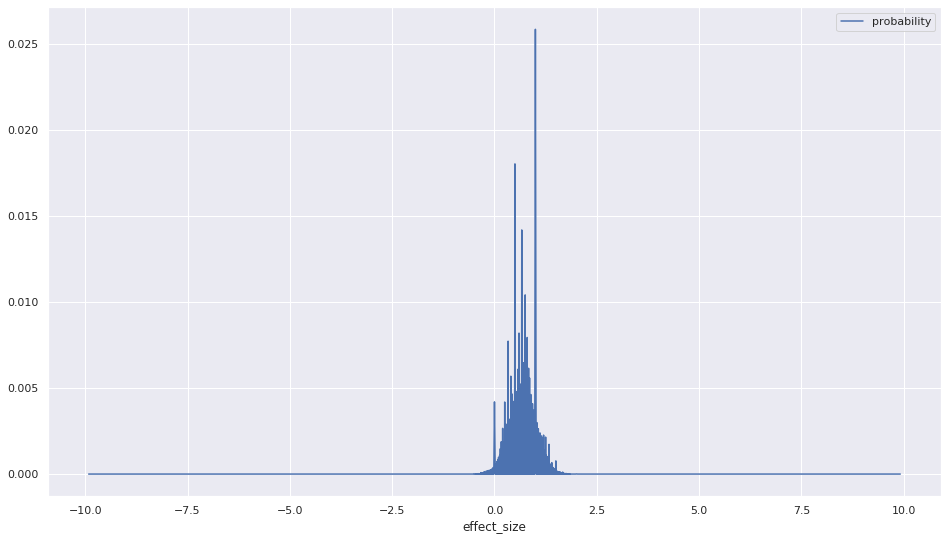

In [155]:
def get_effect_size_distribution_naive(group1, group2):
    effect_size_dist = thinkbayes2.Pmf()
    for (mu_1, sigma_1), prob_1 in group1.SortedItems():
        for (mu_2, sigma_2), prob_2 in group2.SortedItems():
            effect_size_dist.Incr(
                2. * (mu_1 - mu_2) / (sigma_1 + sigma_2),
                prob_1 * prob_2
            )
    return effect_size_dist


effect_size_dist_naive = get_effect_size_distribution_naive(group_treated, control_group)
sns.lineplot(
    data=pd.DataFrame(
        [(effect, prob) for effect, prob in effect_size_dist_naive.SortedItems() if -10. < effect < 10.],
        columns=['effect_size', 'probability']
    ).set_index('effect_size'),
)

You can observe in the picture that the signal is jumping up and down from zero to some probability value, but it does not look discrete at all. Now I try to fix that by rounding the effect size. This way we add up more probabilities when there is a match for the rounded effect size.

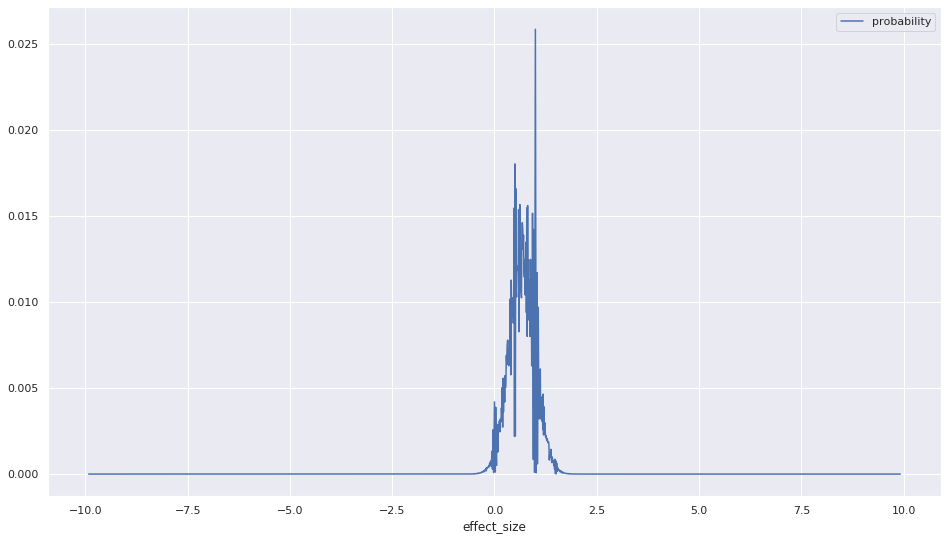

In [156]:
def get_effect_size_distribution_rounding(group1, group2, rounding_digits):
    effect_size_dist = thinkbayes2.Pmf()
    for (mu_1, sigma_1), prob_1 in group1.SortedItems():
        for (mu_2, sigma_2), prob_2 in group2.SortedItems():
            effect_size_dist.Incr(
                round(2. * (mu_1 - mu_2) / (sigma_1 + sigma_2), rounding_digits),
                prob_1 * prob_2
            )
    return effect_size_dist

effect_size_dist = get_effect_size_distribution_rounding(group_treated, control_group, 2)
sns.lineplot(
    data=pd.DataFrame(
        [(effect, prob) for effect, prob in effect_size_dist.SortedItems() if -10. < effect < 10.],
        columns=['effect_size', 'probability']
    ).set_index('effect_size'),
)

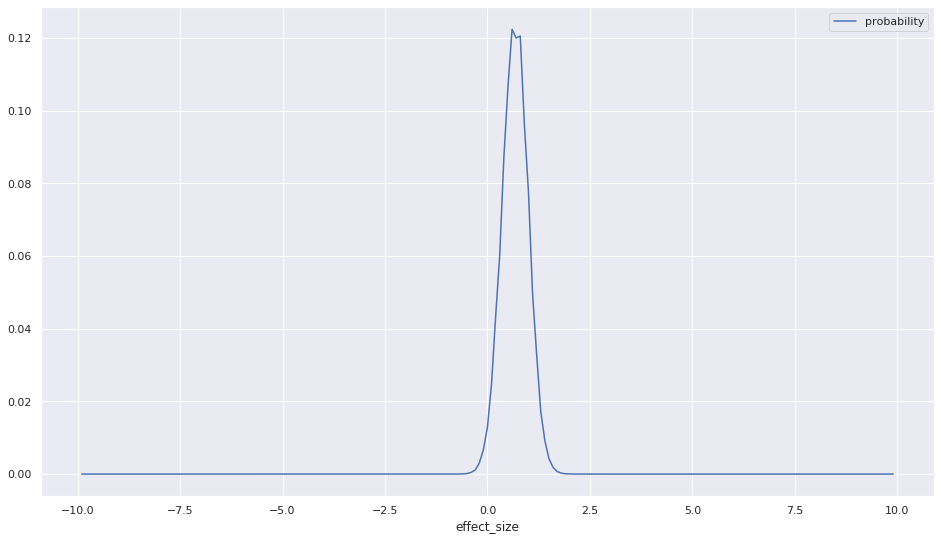

In [157]:
effect_size_dist = get_effect_size_distribution_rounding(group_treated, control_group, 1)
sns.lineplot(
    data=pd.DataFrame(
        [(effect, prob) for effect, prob in effect_size_dist.SortedItems() if -10. < effect < 10.],
        columns=['effect_size', 'probability']
    ).set_index('effect_size'),
)

The distribution looks a bit better, when we round to two digits. For one digits it nearly looks smooth. But actually we would like to choose the discretization steps before and approach the problem with a setup of prior likelihood and posterior. So let us do that. We can marginalize the joint probability distributions:

$ P(\mu_1) = \sum_{\sigma_1} P( \mu_1, \sigma_1 )  $

In [158]:
def marginalize(dist_suite, idx):
    marginalized = thinkbayes2.Pmf()
    for key_tuple, prob in dist_suite.SortedItems():
        marginalized.Incr(
            key_tuple[idx],
            prob
        )
    return marginalized

mu_treated = marginalize(group_treated, 0)
sig_treated = marginalize(group_treated, 1)
mu_control = marginalize(control_group, 0)
sig_control = marginalize(control_group, 1)



We compute the distributions for the numerator and the denominator. 

$ e = \frac n d $

Then we discretize the distribution for $ e $ and take all possible combination for the numerator $n$. 
Then we compute the value for $d $ and interpolate the probability for that exact value.


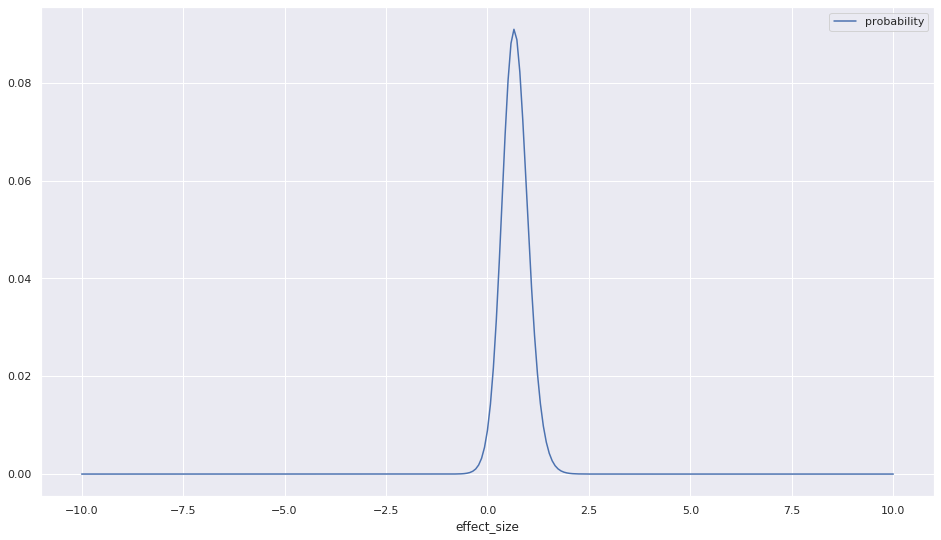

In [175]:
import math

numerator = (mu_treated - mu_control) * thinkbayes2.Pmf({2: 1.})
denominator = (sig_treated + sig_control)

effect_size = thinkbayes2.Pmf()
for value in np.linspace(-10., 10., 277):
    effect_size.Set(value, 0.)

for denom, denom_prob in denominator.SortedItems():
    for effect, effect_prob in effect_size.SortedItems():
        numerator_value = effect * denom
        effect_size.Incr(
            effect,
            denom_prob  * (
                (numerator_value - math.floor(numerator_value)) * numerator[math.ceil(numerator_value)]
                + (1. - (numerator_value - math.floor(numerator_value))) * numerator[math.floor(numerator_value)]
            ) / 2.
        )
effect_size.Normalize()

sns.lineplot(
    data=pd.DataFrame(
        [(effect, prob) for effect, prob in effect_size.SortedItems() if -20. < effect < 20.],
        columns=['effect_size', 'probability']
    ).set_index('effect_size'),
)

So there might be an effect. Let us check the probabilities for a positiv effect and a negative effect with

In [183]:
effect_size.MakeCdf()[0.], (1. - effect_size.MakeCdf()[0.])

(0.02182342559996072, 0.9781765744000392)

So the probability that there is a positive effect is nearly 98%.

Now let's try the whole thing with log likelyhoods to check if it works better. Even though it is not expected for such a small dataset.

In [161]:
import itertools
mu_hypos, sigma_hypos = np.linspace(20, 80, 121), np.linspace(1, 30, 30)

hypo_combs_log = list(itertools.product(mu_hypos, sigma_hypos))


def get_log_suite(skill_data):
    def log_likelyhoods(data_points, hypo):
        mu, sigma = hypo
        return sum([
            scp.stats.norm.logpdf((data - mu) / sigma) - math.log(sigma)
            for data in data_points
        ])

    treat_log_probs = {
        hypo: log_likelyhoods(skill_data, hypo)
        for hypo in hypo_combs_log
    }

    maximal_log_prob = max(treat_log_probs.values())
    suite =  ReadingGroup({hypo: math.exp(log_prob - maximal_log_prob) for hypo, log_prob in treat_log_probs.items()})
    suite.Normalize()
    return suite
treatment_group_log = get_log_suite(skills_one)
control_group_log = get_log_suite(skills_two)

mu_treated_log = marginalize(treatment_group_log, 0)
sig_treated_log = marginalize(treatment_group_log, 1)
mu_control_log = marginalize(control_group_log, 0)
sig_control_log = marginalize(control_group_log, 1)

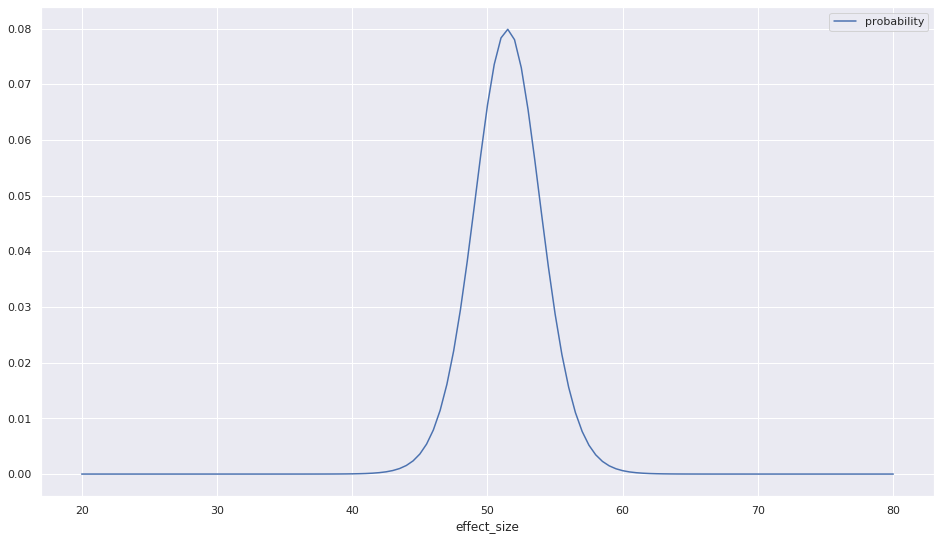

In [162]:
sns.lineplot(
    data=pd.DataFrame(
        [(effect, prob) for effect, prob in mu_treated_log.SortedItems()],
        columns=['effect_size', 'probability']
    ).set_index('effect_size'),
)

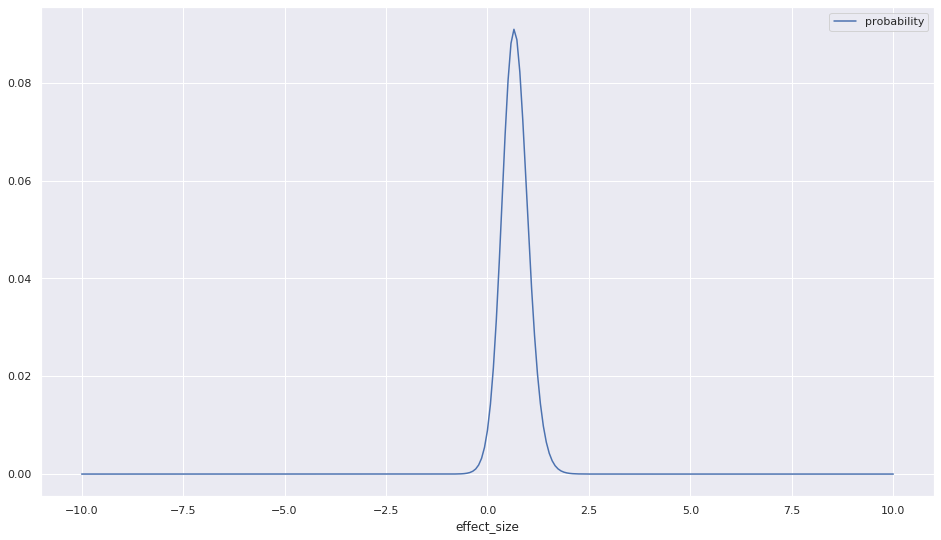

In [174]:
numerator_log = (mu_treated_log - mu_control_log) * thinkbayes2.Pmf({2: 1.})
denominator_log = (sig_treated_log + sig_control_log)

effect_size_log = thinkbayes2.Pmf()
for value in np.linspace(-10., 10., 277):
    effect_size_log.Set(value, 0.)

for denom, denom_prob in denominator_log.SortedItems():
    for effect, effect_prob in effect_size_log.SortedItems():
        numerator_value = effect * denom
        effect_size_log.Incr(
            effect,
            denom_prob  * (
                (numerator_value - math.floor(numerator_value)) * numerator_log[math.ceil(numerator_value)]
                + (1. - (numerator_value - math.floor(numerator_value))) * numerator_log[math.floor(numerator_value)]
            ) / 2.
        )
effect_size_log.Normalize()

sns.lineplot(
    data=pd.DataFrame(
        [(effect, prob) for effect, prob in effect_size_log.SortedItems() if -20. < effect < 20.],
        columns=['effect_size', 'probability']
    ).set_index('effect_size'),
)
